<a href="https://colab.research.google.com/github/kotireddys/masters_thesis/blob/main/Thesis_2_datasetcreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cropped aerial GeoTIFF (with alpha/NoData outside the footprint), and writes 512×512 tiles only where all pixels are valid—so no black/no-data tiles make it into the dataset.

In [ ]:
# 512×512 tiles from CROPPED AERIAL — keep ONLY full-valid tiles (no black/no-data)
# Outputs: GeoTIFF tiles (georeferenced) + manifest.csv
!pip install rasterio
import os, csv
import numpy as np
import rasterio as rio
from rasterio.windows import Window
from rasterio.windows import bounds as window_bounds

# ---- INPUT ----
AERIAL = "/content/drive/MyDrive/Thesis/Simulate US D1/Results/aerial_footprint_cropped.tif"   # your already-cropped aerial

# ---- OUTPUT ----
OUT_IMG_DIR  = "/content/drive/MyDrive/Thesis/dataset/images"
MANIFEST_CSV = "/content/drive/MyDrive/Thesis/dataset/manifest.csv"

# ---- PARAMS ----
TILE         = 512      # patch size
OVERLAP      = 0        # e.g., 128 for overlap
COVERAGE_MIN = 1.00     # require 100% valid coverage (strict: no black/no-data at all)
BUFFER_PX    = 0        # set >0 to erode mask a bit so edge tiles are ultra clean

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MANIFEST_CSV), exist_ok=True)

with rio.open(AERIAL) as a_ds:
    H, W = a_ds.height, a_ds.width
    stride = TILE - OVERLAP
    n = 0

    fieldnames = ["tile_id","row","col","xoff","yoff","width","height",
                  "img_path","coverage","minx","miny","maxx","maxy"]
    with open(MANIFEST_CSV, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()

        for r0 in range(0, H - TILE + 1, stride):
            for c0 in range(0, W - TILE + 1, stride):
                r1, c1 = r0 + TILE, c0 + TILE
                win = Window.from_slices((r0, r1), (c0, c1))

                # Validity from alpha/NoData (255 valid, 0 nodata)
                mask_tile = a_ds.read_masks(1, window=win) > 0

                # Optional inward buffer to avoid feathered edges
                if BUFFER_PX > 0:
                    try:
                        import cv2
                        kernel = np.ones((BUFFER_PX, BUFFER_PX), np.uint8)
                        mask_tile = cv2.erode(mask_tile.astype(np.uint8)*255, kernel, iterations=1) > 0
                    except Exception:
                        pass  # skip buffering if OpenCV not available

                cov = mask_tile.mean()
                if cov < COVERAGE_MIN:
                    continue  # skip anything not fully valid

                # Read imagery (RGB or single-band)
                if a_ds.count >= 3:
                    img_tile = a_ds.read([1,2,3], window=win)
                    out_count = 3
                else:
                    img_tile = a_ds.read(1, window=win)[None, ...]
                    out_count = 1

                # Write GeoTIFF tile with subset transform and the mask preserved
                tform = a_ds.window_transform(win)
                tile_id = f"r{r0}_c{c0}"
                img_out = os.path.join(OUT_IMG_DIR, f"{tile_id}.tif")

                img_meta = a_ds.meta.copy()
                img_meta.update({
                    "height": TILE, "width": TILE,
                    "transform": tform, "count": out_count
                })
                with rio.open(img_out, "w", **img_meta) as dst:
                    dst.write(img_tile)
                    dst.write_mask((mask_tile.astype(np.uint8) * 255))

                # Manifest row with geo bounds
                minx, miny, maxx, maxy = window_bounds(win, a_ds.transform)
                w.writerow({
                    "tile_id": tile_id,
                    "row": r0, "col": c0,
                    "xoff": c0, "yoff": r0, "width": TILE, "height": TILE,
                    "img_path": img_out, "coverage": round(float(cov), 4),
                    "minx": minx, "miny": miny, "maxx": maxx, "maxy": maxy
                })
                n += 1

print(f"✅ Wrote {n} clean tiles (512×512) to {OUT_IMG_DIR}")
print(f"📄 Manifest: {MANIFEST_CSV}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 84.6 MB/s eta 0:00:00
✅ Wrote 525 clean tiles (512×512) to /content/drive/MyDrive/Thesis/dataset/images
📄 Manifest: /content/drive/MyDrive/Thesis/dataset/manifest.csv


Rename tiles to a sequential scheme and update the manifest

In [ ]:
# Rename image tiles sequentially and write a new manifest; then preview samples

import os, shutil, pandas as pd, rasterio as rio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

IMG_DIR = "/content/drive/MyDrive/Thesis/dataset/images"
MANIFEST_IN  = "/content/drive/MyDrive/Thesis/dataset/manifest.csv"
MANIFEST_OUT = "/content/drive/MyDrive/Thesis/dataset/manifest_renamed.csv"
PREFIX = "tile_"   # change if you prefer another prefix

# --- load & sort tiles by position for predictable order ---
df = pd.read_csv(MANIFEST_IN)
df = df.sort_values(["yoff", "xoff"]).reset_index(drop=True)

# --- build new names ---
pad = len(str(len(df)))
new_ids = [f"{PREFIX}{i+1:0{pad}d}" for i in range(len(df))]
df["old_tile_id"] = df["tile_id"]
df["old_img_path"] = df["img_path"]

# --- rename files on disk and update paths in the dataframe ---
renamed = 0
for i, row in df.iterrows():
    old_path = Path(row["img_path"])
    new_name = f"{new_ids[i]}.tif"
    new_path = old_path.with_name(new_name)

    # if destination exists, bail to avoid collisions
    if new_path.exists():
        raise FileExistsError(f"Destination already exists: {new_path}")

    # rename (move) the file
    old_path.rename(new_path)

    # update dataframe fields
    df.loc[i, "tile_id"] = new_ids[i]
    df.loc[i, "img_path"] = str(new_path)
    renamed += 1

# --- write new manifest (keep geo columns + old mapping for traceability) ---
cols = ["tile_id","row","col","xoff","yoff","width","height",
        "img_path","coverage","minx","miny","maxx","maxy",
        "old_tile_id","old_img_path"]
df.to_csv(MANIFEST_OUT, index=False)
print(f"✅ Renamed {renamed} files.")
print("📄 New manifest:", MANIFEST_OUT)


✅ Renamed 525 files.
📄 New manifest: /content/drive/MyDrive/Thesis/dataset/manifest_renamed.csv


Visualize a few random samples (post-rename)

Tiles in dataset: 525


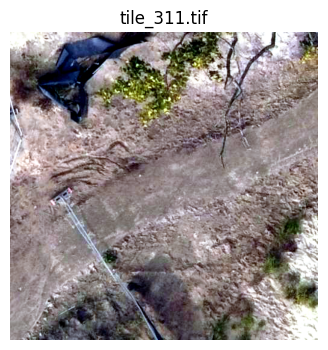

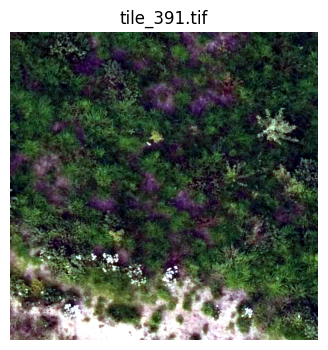

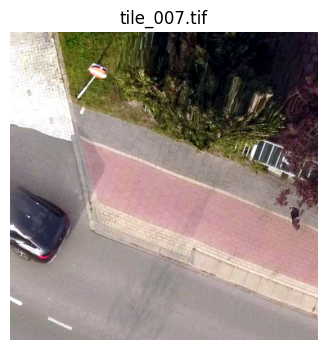

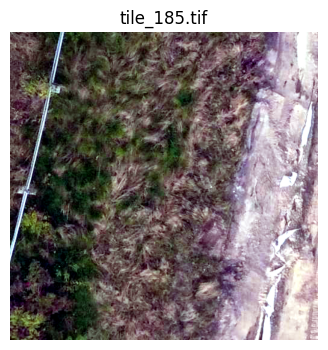

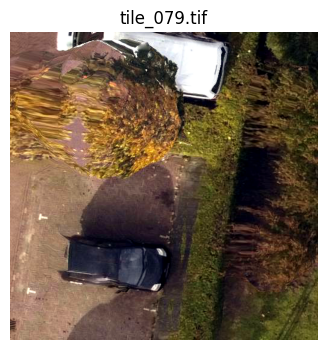

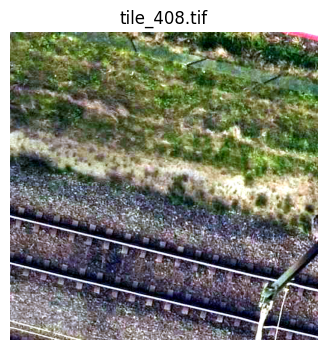

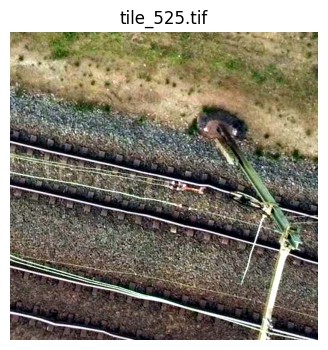

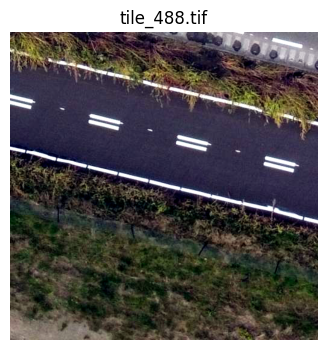

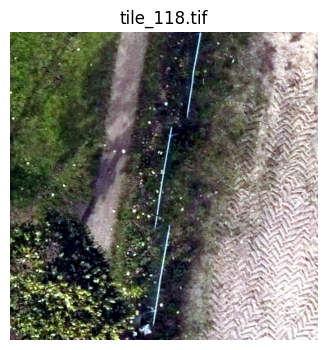

In [ ]:
# Quick visual check of random samples (uses the NEW manifest)
import pandas as pd, numpy as np, rasterio as rio, matplotlib.pyplot as plt
from pathlib import Path
import random

MANIFEST = "/content/drive/MyDrive/Thesis/dataset/manifest_renamed.csv"
SAMPLES  = 9

df = pd.read_csv(MANIFEST)
print(f"Tiles in dataset: {len(df)}")

def normalize01(chan):
    vmin, vmax = np.percentile(chan, [2, 98])
    return np.clip((chan - vmin) / max(vmax - vmin, 1e-6), 0, 1)

def checkerboard(h, w, size=32):
    rr, cc = np.indices((h, w))
    chk = ((rr // size) + (cc // size)) % 2
    return np.where(chk[..., None]==0, 0.85, 0.65).astype(np.float32)

for _, row in df.sample(min(SAMPLES, len(df)), random_state=42).iterrows():
    p = row["img_path"]
    with rio.open(p) as ds:
        if ds.count >= 3:
            arr = ds.read([1,2,3]).astype(np.float32)
            arr = np.moveaxis(arr, 0, -1)
            for b in range(3):
                arr[..., b] = normalize01(arr[..., b])
        else:
            b = ds.read(1).astype(np.float32)
            b = normalize01(b)
            arr = np.repeat(b[..., None], 3, axis=-1)

        mask = ds.read_masks(1) > 0
        bg = checkerboard(mask.shape[0], mask.shape[1])
        vis = np.where(mask[..., None], arr, bg)

    plt.figure(figsize=(4,4))
    plt.imshow(vis)
    plt.title(Path(p).name)
    plt.axis('off')
    plt.show()


Code to convert .tif patches → .png

In [ ]:
import os
from pathlib import Path
import rasterio as rio
import numpy as np
from PIL import Image
from tqdm import tqdm

IN_DIR  = "/content/drive/MyDrive/Thesis/dataset/images"
OUT_DIR = "/content/drive/MyDrive/Thesis/dataset_png/images"
os.makedirs(OUT_DIR, exist_ok=True)

def norm01(x):
    vmin,vmax = np.percentile(x,[2,98])
    return np.clip((x-vmin)/max(vmax-vmin,1e-6),0,1)

tifs = sorted(Path(IN_DIR).glob("*.tif"))
for tif in tqdm(tifs, desc="Converting"):
    with rio.open(tif) as ds:
        if ds.count>=3:
            arr = ds.read([1,2,3]).astype(np.float32)
            arr = np.moveaxis(arr,0,-1)
            for b in range(3): arr[...,b]=norm01(arr[...,b])
        else:
            b = ds.read(1).astype(np.float32)
            arr = np.repeat(norm01(b)[...,None],3,axis=-1)

        alpha = (ds.read_masks(1)>0).astype(np.uint8)*255
        rgba  = np.dstack([(arr*255).astype(np.uint8), alpha])

    out = Path(OUT_DIR)/ (tif.stem+".png")
    Image.fromarray(rgba, mode="RGBA").save(out, optimize=True)

print(f"✅ Converted {len(tifs)} tiles to PNG → {OUT_DIR}")


Converting:   0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipython-input-1099675971.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba, mode="RGBA").save(out, optimize=True)
Converting: 100%|██████████| 525/525 [04:27<00:00,  1.96it/s]

✅ Converted 525 tiles to PNG → /content/drive/MyDrive/Thesis/dataset_png/images
